# Прунинг и спарсификация сетей

На лекции мы обсуждали основы прунинга и спрарсификации нейронных сетей, а теперь попробуем самостоятельно реализовать некоторые подходы и посмотрим, какое влияние они оказывают на практике

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from time import time
from copy import deepcopy
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
import torch.nn.utils.prune as prune


Прунинг — это удаление связей в нейронной сети с целью улучшения обобщения и сокращения вычислительных ресурсов.

Для начала создадим простую нейронную сеть и подготовим данные для нее.

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 908248.23it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 132610.33it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1277887.03it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8726765.35it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

image shape: torch.Size([256, 1, 28, 28]) 
 label shape: torch.Size([256])


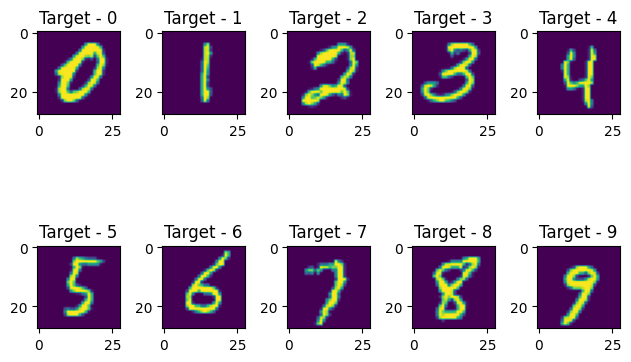

In [4]:
def load_MNIST():
    """Function to load and normalize MNIST data"""
    transform = transforms.Compose([
        transforms.RandomRotation(10),  # Rotate images by up to 10 degrees
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize the images
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Load MNIST dataset
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

    # Data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)
    return train_dataset, test_dataset, train_loader, test_loader

def visualize_MNIST(train_loader):
    """Function to visualize data given a DataLoader object"""
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    print("image shape:", images.shape, "\n label shape:", labels.shape)
    # visualize data
    fig, ax = plt.subplots(2,5)
    for i, ax in enumerate(ax.flatten()):
        im_idx = np.argwhere(labels == i)[0][0]
        plottable_image = images[im_idx].squeeze()
        ax.imshow(plottable_image)
        ax.set_title(f"Target - {i}")
    plt.tight_layout()

# load and visualize MNISt
train, test, train_loader, test_loader = load_MNIST()
visualize_MNIST(train_loader)

In [5]:
def train_epoch(model, device, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data, target in tqdm(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy


def evaluate(model, device, dataloader):
    model.eval()
    correct = 0
    total = 0
    total_time = 0
    with torch.no_grad():
        for data, target in tqdm(dataloader):
            data, target = data.to(device), target.to(device)
            start = time()
            outputs = model(data)
            total_time += time() - start
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    mean_time = total_time / len(dataloader)
    accuracy = 100 * correct / total
    return accuracy, mean_time


def full_train(
    model,
    device,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    num_epochs=10,
):
    metrics = defaultdict(list)
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        train_loss, train_accuracy = train_epoch(
            model, device, train_loader, optimizer, criterion
        )
        test_accuracy, mean_time = evaluate(model, device, test_loader)
        metrics["train_loss"].append(train_loss)
        metrics["train_accuracy"].append(train_accuracy)
        metrics["test_accuracy"].append(test_accuracy)
        metrics["mean_time"].append(mean_time)
        pbar.set_postfix_str(
            f"Epoch {epoch+1}, Train Loss: {round(train_loss, 4)}, "
            f"Train Acc: {round(train_accuracy, 4)}| "
            f"Test Acc: {round(test_accuracy, 4)}"
        )
    return pd.DataFrame(metrics)

In [7]:
class VGG(nn.Module):
    def __init__(self, size=1):
        super().__init__()
        assert isinstance(size, int) and size > 0
        self.features = nn.Sequential(
            nn.Conv2d(1, 32 * size, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32 * size, 64 * size, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64 * size, 128 * size, kernel_size=3), # 128*size x 5 x 5
            nn.ReLU(),
            nn.Conv2d(128 * size, 128 * size, kernel_size=3, padding="same"), # 128*size x 5 x 5
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(2),
            nn.Flatten()
        )
        cl_size = 128
        self.classifier = nn.Sequential(
            nn.Linear(128 * size * 2 * 2, cl_size * size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(cl_size * size, cl_size * size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(cl_size * size, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [48]:
model = VGG(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [10]:
result = full_train(
    model, device, train_loader, test_loader, optimizer, criterion, num_epochs=5
)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [11]:
pretrained_model = deepcopy(model)

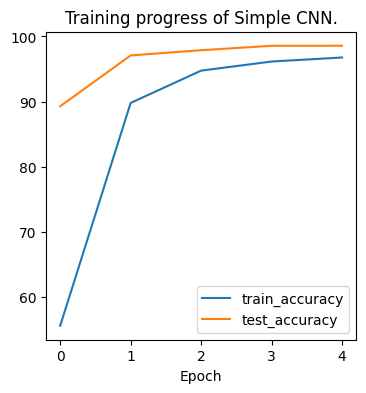

In [12]:
def plot_train_progress(df, title):
    plt.figure(figsize=(4,4))
    plt.title(f"Training progress of {title}.")
    plt.plot(df["train_accuracy"], label="train_accuracy")
    plt.plot(df["test_accuracy"], label="test_accuracy")
    plt.xlabel("Epoch")
    plt.legend()

plot_train_progress(result, "Simple CNN")

Почему качество на трейне меньше чем на тесте?

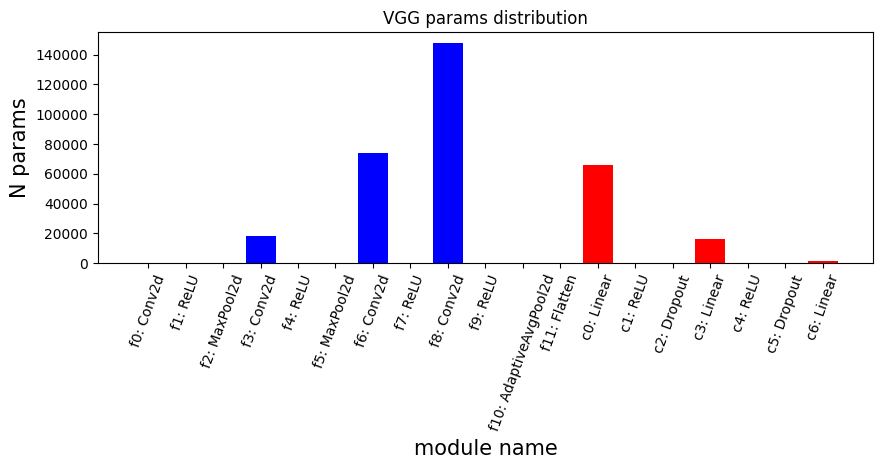

In [13]:
def show_param_numbers(model):
    plt.figure(figsize=(10, 3))
    x_labels = []
    y = []
    for i, module in enumerate(model.features):
        x_labels += [f"f{i}: {type(module).__name__}"]
        y += [sum(p.numel() for p in module.parameters() if p.requires_grad)]
    colors = ["blue"] * len(y)
    for i, module in enumerate(model.classifier):
        x_labels += [f"c{i}: {type(module).__name__}"]
        y += [sum(p.numel() for p in module.parameters() if p.requires_grad)]
    colors += ["red"] * (len(y) - len(colors))
    plt.bar(x_labels, y, color=colors)
    plt.xticks(rotation=70)
    plt.xlabel("module name", fontsize=15)
    plt.ylabel("N params", fontsize=15)
    plt.title("VGG params distribution")
show_param_numbers(VGG(1))

## Начнем прунинг

Сама по себе техника довольно простая и не очень новая, поэтому уже есть некоторые имплементации ее в самом торче.

Можно посмотреть самостоятельно гайд по использованию torch.nn.utils.prune здесь:
https://pytorch.org/tutorials/intermediate/pruning_tutorial.html

In [14]:
model = deepcopy(pretrained_model)

In [15]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): AdaptiveAvgPool2d(output_size=2)
    (11): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [16]:
import torch.nn.utils.prune as prune
module = deepcopy(model.features[0])
# list(module.named_parameters())
list(module.named_parameters())[0][1].shape
# list(module.named_buffers())

torch.Size([32, 1, 3, 3])

In [20]:
prune.ln_structured(module, "weight", 0.2, 2, 0)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [21]:
# list(module.named_parameters())
# list(module.named_parameters())[0][1].shape
list(module.named_buffers())
# module.weight

[('weight_mask',
  tensor([[[[1., 1., 1.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[0., 0., 0.],
            [0., 0., 0.],
            [0., 0., 0.]]],
  
  
          [[[0., 0., 0.],
            [0., 0., 0.],
            [0., 0., 0.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[0., 0., 0.],
            [0., 0., 0.],
            [0., 0., 0.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[0., 0., 0.],
           

In [22]:
prune.l1_unstructured(module, "weight", 0.2)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [23]:
list(module.named_buffers())


[('weight_mask',
  tensor([[[[1., 0., 1.],
            [0., 1., 0.],
            [1., 1., 1.]]],
  
  
          [[[0., 0., 0.],
            [0., 0., 0.],
            [0., 0., 0.]]],
  
  
          [[[0., 0., 0.],
            [0., 0., 0.],
            [0., 0., 0.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[1., 1., 0.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[0., 0., 1.],
            [1., 1., 1.],
            [0., 1., 0.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 0.],
            [1., 1., 1.]]],
  
  
          [[[1., 1., 1.],
            [0., 0., 1.],
            [1., 0., 1.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 1.],
            [0., 1., 1.]]],
  
  
          [[[0., 0., 0.],
            [0., 0., 0.],
            [0., 0., 0.]]],
  
  
          [[[1., 0., 0.],
            [1., 0., 0.],
            [1., 1., 1.]]],
  
  
          [[[0., 0., 0.],
           

In [24]:
for hook in module._forward_pre_hooks.values():
    if hook._tensor_name == "weight":  # select out the correct hook
        break

print(list(hook))

[<torch.nn.utils.prune.LnStructured object at 0x7f45745f6800>, <torch.nn.utils.prune.L1Unstructured object at 0x7f45745f6050>]


In [25]:
list(module.named_parameters())
prune.remove(module, 'weight')


Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [27]:
list(module.named_buffers())
module.weight

Parameter containing:
tensor([[[[-0.3551,  0.0000, -0.2126],
          [-0.0000,  0.1590,  0.0000],
          [ 0.3878,  0.3050, -0.2462]]],


        [[[-0.0000, -0.0000, -0.0000],
          [-0.0000,  0.0000, -0.0000],
          [-0.0000, -0.0000,  0.0000]]],


        [[[-0.0000,  0.0000, -0.0000],
          [-0.0000,  0.0000, -0.0000],
          [ 0.0000, -0.0000, -0.0000]]],


        [[[ 0.2236,  0.1586, -0.2740],
          [ 0.2961, -0.2789, -0.1593],
          [ 0.3513,  0.3974, -0.3033]]],


        [[[ 0.2198,  0.3603,  0.0000],
          [ 0.2959,  0.1351, -0.2230],
          [-0.4109, -0.1139, -0.2425]]],


        [[[ 0.0000, -0.0000,  0.2094],
          [ 0.3589,  0.1157, -0.4536],
          [-0.0000,  0.3781,  0.0000]]],


        [[[ 0.1471, -0.2764, -0.2029],
          [ 0.2453, -0.1357, -0.0000],
          [ 0.1866,  0.2116,  0.2722]]],


        [[[ 0.1104,  0.3239, -0.2968],
          [-0.0000, -0.0000,  0.2382],
          [-0.3254, -0.0000,  0.1787]]],


        [[

## Вспомогательные функции

In [28]:
model.features[0].weight.shape

torch.Size([32, 1, 3, 3])

In [29]:
def iterative_pruning(model, pruning_method, train_loader, test_loader, device, num_iterations=10, save_models=False):
    # Initialize dictionary to store metrics
    metrics = defaultdict(list)

    # Calculate the initial total number of weights
    initial_weights = sum(p.numel() for p in model.parameters() if p.requires_grad)
    remaining_rate = 1
    prune_rate = 1 / num_iterations
    print(f"Initial Prune_rate = {prune_rate}")

    # Record initial model performance
    initial_accuracy, _ = evaluate(model, device, test_loader)
    metrics['number_of_parameters'].append(initial_weights)
    metrics['accuracy'].append(initial_accuracy)
    metrics['accuracy_right_after_pruning'].append(initial_accuracy)
    models = []

    for iteration in range(num_iterations):
        # Calculate the effective pruning rate
        effective_pruning_rate = min(prune_rate / remaining_rate, 0.5)
        print(f"Effective pruning rate for iteration {iteration+1}: {effective_pruning_rate}")

        # Prune the model
        pruning_method(model, pruning_rate=effective_pruning_rate)
        post_prune_accuracy, _ = evaluate(model, device, test_loader)
        metrics['accuracy_right_after_pruning'].append(post_prune_accuracy)

        # Train for one epoch
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = torch.nn.CrossEntropyLoss()
        train_epoch(model, device, train_loader, optimizer, criterion)

        # Evaluate the model
        accuracy, _ = evaluate(model, device, test_loader)

        # Update remaining rate and record metrics
        remaining_rate = (sum(mask.sum() for name, mask in model.named_buffers()) / initial_weights).item()
        if save_models:
            models += [deepcopy(model)]
        else:
            models = model
        metrics['number_of_parameters'].append(remaining_rate * initial_weights)
        metrics['accuracy'].append(accuracy)
        print(f"Iteration {iteration + 1}, Test Accuracy: {accuracy:.2f}%, Remaining Parameters: {remaining_rate * initial_weights}")

    return metrics, models

In [30]:
def magnitude_global_pruning(model, pruning_rate):
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)) and name != "classifier.6":
            parameters_to_prune.append((module, 'weight'))
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_rate,
    )

def magnitude_local_pruning(model, pruning_rate):
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)) and name != "classifier.6":
            prune.l1_unstructured(module, name="weight", amount=pruning_rate)

def l2_structured_pruning(model, pruning_rate):
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)) and name != "classifier.6":
            prune.ln_structured(module, name="weight", amount=pruning_rate, n=2, dim=0)
            if module.bias is not None:
                weight_mask = [mask for name, mask in module.named_buffers() if name == "weight_mask"][0]
                bias_mask = weight_mask.abs().sum(dim=tuple(range(1, len(weight_mask.shape)))) != 0
                prune.custom_from_mask(module, "bias", bias_mask)


def finalize_model_pruning(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)) and prune.is_pruned(module):
            prune.remove(module, 'weight')
            prune.remove(module, 'bias')


In [31]:
metrics, model = iterative_pruning(deepcopy(pretrained_model), magnitude_global_pruning, train_loader, test_loader, device, num_iterations=4)

Initial Prune_rate = 0.25


  0%|          | 0/40 [00:00<?, ?it/s]

Effective pruning rate for iteration 1: 0.25


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Iteration 1, Test Accuracy: 98.77%, Remaining Parameters: 241368.00596928596
Effective pruning rate for iteration 2: 0.3352992028707334


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Iteration 2, Test Accuracy: 98.83%, Remaining Parameters: 160438.00764799118
Effective pruning rate for iteration 3: 0.5


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Iteration 3, Test Accuracy: 99.06%, Remaining Parameters: 80219.00382399559
Effective pruning rate for iteration 4: 0.5


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Iteration 4, Test Accuracy: 99.24%, Remaining Parameters: 40109.00023329258


In [33]:
all_results = {"magnitude_global_pruning": metrics}

[0.0, 25.439727306365967, 50.43957233428955, 75.21978616714478, 87.6100480556488]
[98.57, 98.77, 98.83, 99.06, 99.24]


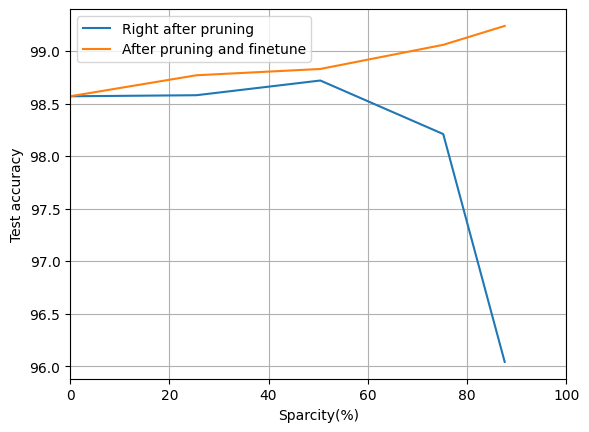

In [34]:
def plot_pruning_results(result):
    x = []
    y_before = []
    y_after = []
    for i in range(len(result["number_of_parameters"])):
        x += [100 - result["number_of_parameters"][i] / result["number_of_parameters"][0] * 100]
        y_before += [result["accuracy_right_after_pruning"][i]]
        y_after += [result["accuracy"][i]]
    plt.plot(x, y_before, label="Right after pruning")
    plt.plot(x, y_after, label="After pruning and finetune")
    plt.xlabel("Sparcity(%)")
    plt.ylabel("Test accuracy")
    plt.xlim(0, 100)
    plt.grid()
    plt.legend()
    print(x)
    print(y_after)

plot_pruning_results(all_results["magnitude_global_pruning"])

## Качество даже улучшалось вплоть до уменьшения размера в 7 раз!

In [35]:
metrics, structured_models = iterative_pruning(deepcopy(pretrained_model), l2_structured_pruning, train_loader, test_loader, device, num_iterations=4, save_models=True)

Initial Prune_rate = 0.25


  0%|          | 0/40 [00:00<?, ?it/s]

Effective pruning rate for iteration 1: 0.25


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Iteration 1, Test Accuracy: 98.74%, Remaining Parameters: 241824.012616992
Effective pruning rate for iteration 2: 0.33466693040190393


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Iteration 2, Test Accuracy: 98.75%, Remaining Parameters: 161216.00519543886
Effective pruning rate for iteration 3: 0.5


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Iteration 3, Test Accuracy: 96.45%, Remaining Parameters: 80608.00259771943
Effective pruning rate for iteration 4: 0.5


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Iteration 4, Test Accuracy: 89.45%, Remaining Parameters: 40304.001298859715


In [36]:
all_results["l2_structured_pruning"] = metrics

[0.0, 25.298863649368286, 50.19924342632294, 75.09962171316147, 87.54981085658073]
[98.57, 98.74, 98.75, 96.45, 89.45]


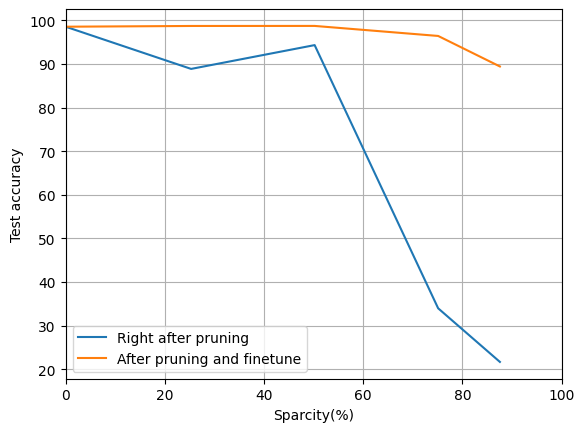

In [37]:
plot_pruning_results(all_results["l2_structured_pruning"])

## Даже используя структурный прунинг мы смогли уменьшить размер в 4 раза с небольшими потерями!

### Теперь реализуем настоящий честный структурный прунинг при помощи pytorch. Для этого просто удалим из модели нулевые ядра и нейроны. Возьмем модель на предпоследней итерации - которая в 4 раза меньше

In [38]:
structured_model = structured_models[-2]

In [39]:
def prune_vgg(model):
    new_layers = []
    prev_mask = None
    for layer in model.features + model.classifier:
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            dims = tuple(range(1, len(layer.weight.shape)))
            weight_sums = layer.weight.data.abs().sum(dim=dims)
            assert len(weight_sums.shape) == 1
            mask = weight_sums != 0
            if prev_mask is None:
                prev_mask = torch.ones(layer.weight.shape[1], dtype=torch.bool)
            if isinstance(layer, nn.Linear) and prev_mask.shape[0] < layer.weight.shape[1]:
                # that means we deal with first Linear layer after convolution
                prev_mask = prev_mask.repeat_interleave(layer.weight.shape[1] // prev_mask.shape[0])

            new_layer = (
                nn.Conv2d(
                    prev_mask.sum().item(),
                    mask.sum().item(),
                    layer.kernel_size,
                    stride=layer.stride,
                    padding=layer.padding,
                    bias=layer.bias is not None,
                )
                if isinstance(layer, nn.Conv2d)
                else nn.Linear(
                    prev_mask.sum().item(),
                    mask.sum().item(),
                    bias=layer.bias is not None,
                )
            )
            # print(f"Before: {layer}. After:{new_layer}")
            new_layer.weight.data = layer.weight.data[mask][:, prev_mask]
            new_layer.bias.data = layer.bias.data[mask]
            new_layers += [new_layer]
            prev_mask = mask
        else:
            new_layers += [layer]

    model.features = nn.Sequential(*(new_layers[:len(model.features)]))
    model.classifier = nn.Sequential(*(new_layers[len(model.features):]))
    return model

def eval_time(model, device="cuda"):
    model.eval()
    input_tensor = torch.randn((4096, 1, 28, 28), device=device)
    with torch.no_grad():
        start = time()
        for i in tqdm(range(1000)):
            model(input_tensor)
    return (time() - start) / 1000


real_structured_model = prune_vgg(deepcopy(structured_model))
real_structured_model = real_structured_model.to("cuda")

In [40]:
result = {
    "Structured_pruning(fake)": {
        "Eval accuracy": evaluate(structured_model, 'cuda', test_loader)[0],
        "Num parameters": sum(p.numel() for p in structured_model.parameters() if p.requires_grad),
        "Eval Time": eval_time(structured_model)
    }
}
result["Structured_pruning(real)"] = {
    "Eval accuracy": evaluate(real_structured_model, 'cuda', test_loader)[0],
    "Num parameters": sum(p.numel() for p in real_structured_model.parameters() if p.requires_grad),
    "Eval Time": eval_time(real_structured_model)
}
result = pd.DataFrame(result)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [41]:
result["ratio"] = result["Structured_pruning(fake)"] / result["Structured_pruning(real)"]
result

,Structured_pruning(fake),Structured_pruning(real),ratio
Eval accuracy,96.450000,96.450000,1.000000
Num parameters,323722.000000,20650.000000,15.676610
Eval Time,0.045255,0.012384,3.654411


#### В итоге получаем **чистую** оптимизацию: Меньше параметров в 15 раз и больше скорость в 6 раз.
#### Если вспоминать качество изначальной модели - 98.83, получили эти ускорения пожертвовав 1.5% качества. Если сделать шаги прунинга меньше, то можно получить лучший результат

#### Но подождите! Мы же брали модель, которая в 4 раза уменьшили на каждом слое. Почему после обрезки параметров стало меньше в 15 раз?
#### Все потому, что каждый раз удаляя выходной нейрон в одном слое, мы удаляем входной нейрон в следующем. Поэтому уменьшение возводится в квадрат. Давайте пересчитаем количество параметров более честно.

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[43.622614465498174, 74.82963777562229, 93.62106993037236, 98.36093932448212]
[98.74, 98.75, 96.45, 89.45]


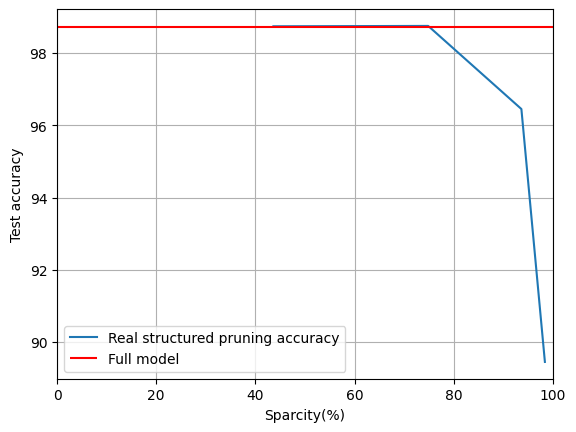

In [42]:
x = []
y_after = []
init_n_weight = sum(p.numel() for p in structured_models[0].parameters() if p.requires_grad)
for i in range(len(structured_models)):
    actual_model = prune_vgg(deepcopy(structured_models[i]))
    new_n = sum(p.numel() for p in actual_model.parameters() if p.requires_grad)
    x += [100 - new_n / init_n_weight * 100]
    y_after += [evaluate(actual_model, 'cuda', test_loader)[0]]
plt.plot(x, y_after, label="Real structured pruning accuracy")
plt.hlines(98.73, 0, 100, label="Full model", colors="r")
plt.xlabel("Sparcity(%)")
plt.ylabel("Test accuracy")
plt.xlim(0, 100)
plt.grid()
plt.legend()
print(x)
print(y_after)

### Теперь выглядит более впечатляюще

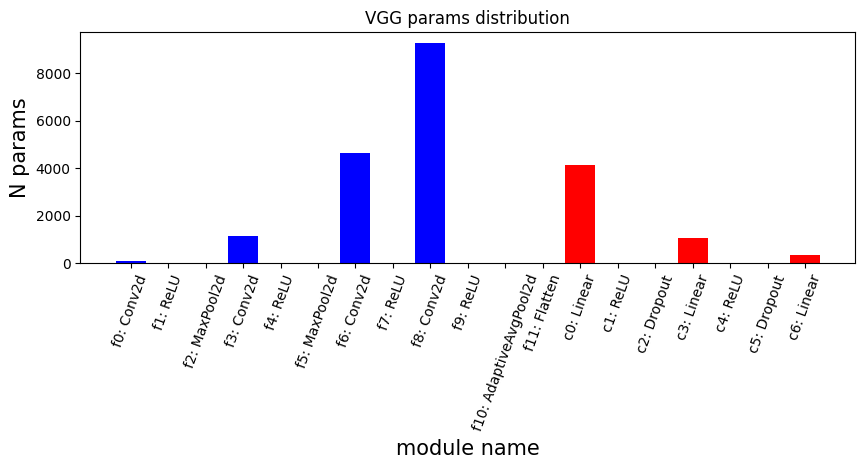

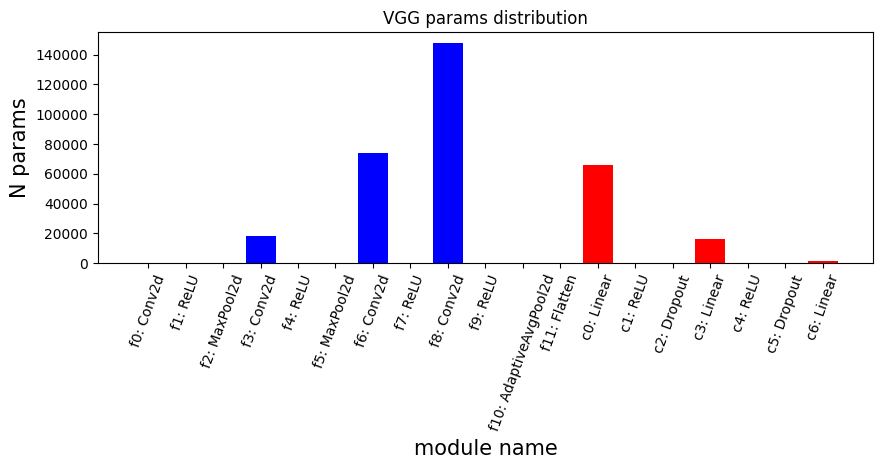

In [ ]:
show_param_numbers(real_structured_model)
show_param_numbers(structured_model)

## Бонус - более умный критерий.
Ниже дан прототип реализации критерия по статье Pruning Convolutional Neural Networks for Resource Efficient Inference.
Это структурный глобальный прунинг, который использует разложение Тейлора до 1го порядка для вычисления важности ядер/нейронов.

Предлагается этот код отладить, запустить и проверить действительно ли он лучше прунинга по магнитуде.

In [ ]:
from torch.nn.utils.prune import BasePruningMethod
class GlobalTaylorPruning(BasePruningMethod):
    PRUNING_TYPE = 'structured'

    @classmethod
    def apply(cls, model, name, pruning_rate):
        # Gather all convolutional layers and their corresponding weights
        layers = []
        for name, module in model.named_modules():
            if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)) and name != "classifier.6":
                layers.append(module)

        # Calculate global importance scores
        global_importance_scores = []
        for layer in layers:
            tensor = layer.weight
            if tensor.grad is None:
                raise ValueError("Gradients are not computed. Ensure backward() has been called.")
            # Calculate importance scores as the mean of the product of weights and their corresponding gradients
            dims = range(1, len(tensor.shape))
            importance_scores = torch.mean(tensor * tensor.grad, dim=dims, keepdim=True).abs()
            assert len(importance_scores.shape) == 1
            importance_scores /= importance_scores ** 2
            global_importance_scores.append(importance_scores)

        # Concatenate all scores and sort them
        all_scores = torch.cat(global_importance_scores)
        num_total_filters = all_scores.numel()
        num_filters_to_prune = int(pruning_rate * num_total_filters)

        # Determine the global threshold
        threshold, _ = torch.kthvalue(all_scores, num_filters_to_prune)

        # Apply the mask globally based on the threshold
        for layer, local_scores in zip(layers, global_importance_scores):
            mask = local_scores.ge(threshold).float().expand_as(layer.weight)
            prune.custom_from_mask(layer, name, mask)

        return model

def global_taylor_pruning(model, pruning_rate=0.05):
    GlobalTaylorPruning.apply(model, 'weight', pruning_rate)

## Neural Network Intelligence
https://nni.readthedocs.io/en/stable/tutorials/pruning_quick_start.html

In [1]:
! pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu121
! pip install nni

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 466.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Successfully uninstalled torch-2.5.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.1+cu121
    Uninstalling torchvision-0.20.1+cu121:
      Successfully uninstalled torchvision-0.20.1+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.5.1+cu121
    Uninstalling torchaudio-2.5.1+cu121:
      Successfully uninstalled torchaudio-2.5.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.1 MB/s eta 0:00:0

In [43]:
def get_num_params(module):
    return sum(p.numel() for p in module.parameters()) / 1000_000

def print_params_up_to_depth(module, max_depth=2, current_depth=0, name="Main"):
    if current_depth <= max_depth:
        print(f"{'  ' * current_depth}{name} {module.__class__.__name__}: {get_num_params(module)} parameters")
        if current_depth < max_depth:
            for subname, submodule in module.named_children():
                print_params_up_to_depth(submodule, max_depth, current_depth + 1, subname)
print_params_up_to_depth(model, 2)

Main VGG: 0.323722 parameters
  features Sequential: 0.240256 parameters
    0 Conv2d: 0.00032 parameters
    1 ReLU: 0.0 parameters
    2 MaxPool2d: 0.0 parameters
    3 Conv2d: 0.018496 parameters
    4 ReLU: 0.0 parameters
    5 MaxPool2d: 0.0 parameters
    6 Conv2d: 0.073856 parameters
    7 ReLU: 0.0 parameters
    8 Conv2d: 0.147584 parameters
    9 ReLU: 0.0 parameters
    10 AdaptiveAvgPool2d: 0.0 parameters
    11 Flatten: 0.0 parameters
  classifier Sequential: 0.083466 parameters
    0 Linear: 0.065664 parameters
    1 ReLU: 0.0 parameters
    2 Dropout: 0.0 parameters
    3 Linear: 0.016512 parameters
    4 ReLU: 0.0 parameters
    5 Dropout: 0.0 parameters
    6 Linear: 0.00129 parameters


In [ ]:
# class Model(nn.Module):
#     def __init__():
#         self.a = nn.Conv2d()
#         self.b = lambda x: None
#     def forward(x):
#         if self.b(x) is None:
#             return self.a(x)
#         return self.b(x)
# x

# a(x) + b(x) #-- skip connection

1. Нельзя скип коннекшены между свертками и линейными слоями.
    - Скип между сверткой и сверткой это ок, но между сверткой и линейным библиотека не распознает
2. Нельзя иметь блоков в модели, которые не используются.
    - Если у модели прописан блок, через него должны проходить данные, иначе библиотека сломается
3. Нельзя возвращать None в выходах модулей. Только тензоры, словари тензоров, списки тензоров

In [62]:
from nni.compression.pruning import (
    L1NormPruner,
    L2NormPruner,
    FPGMPruner,
    LinearPruner
)
from nni.compression.utils import auto_set_denpendency_group_ids
from nni.compression.speedup import ModelSpeedup

In [50]:
config_list = [{
        'op_types': ['Conv2d', "Linear"], # Список модулей, которые надо прунить
        'sparse_ratio': 0.25, # Уровень сжатия
        'exclude_op_names_re': ["classifier.6"], # Исключение блока из прунинга (важно чтобы не получить резкого падения качества)
    }]
dummy_input = torch.zeros(10, 1, 28, 28).cuda() # Библиотека пропускает данные через модель и сама определяет блоки, которые можно прунить
config_list = auto_set_denpendency_group_ids(model, config_list, dummy_input) # Финальный конфиг создается автоматически

In [51]:
config_list

[{'op_names': ['features.8'],
  'sparse_ratio': 0.25,
  'dependency_group_id': 'ea82c37897ba4a2db6578c10002b8cd5',
  'internal_metric_block': 1},
 {'op_names': ['features.6'],
  'sparse_ratio': 0.25,
  'dependency_group_id': 'e6e11e8836c34027814f8624f72ce673',
  'internal_metric_block': 1},
 {'op_names': ['classifier.0'],
  'sparse_ratio': 0.25,
  'dependency_group_id': '7f1fcd330bff469c840d23ae32bfbc67'},
 {'op_names': ['features.0'],
  'sparse_ratio': 0.25,
  'dependency_group_id': '013f3357113045f2bb2c6b16b2210d9c',
  'internal_metric_block': 1},
 {'op_names': ['classifier.3'],
  'sparse_ratio': 0.25,
  'dependency_group_id': '7428fec101e44e10b1d2b25a87a5b86e'},
 {'op_names': ['features.3'],
  'sparse_ratio': 0.25,
  'dependency_group_id': 'ec05e116f20148b097de84a23b2d18bb',
  'internal_metric_block': 1}]

In [52]:
pruner = L1NormPruner(model, config_list)

In [53]:
compress, masks = pruner.compress()


In [58]:
model.features[0]

Conv2d(
  1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same
  (_nni_wrapper): ModuleWrapper(module=Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same), module_name=features.0)
)

In [59]:
pruner.unwrap_model()


In [60]:
model = ModelSpeedup(model, dummy_input, masks).speedup_model()

[2024-11-25 17:31:23] Start to speedup the model...


INFO:nni.compression.speedup.model_speedup:Start to speedup the model...


[2024-11-25 17:31:23] Resolve the mask conflict before mask propagate...


INFO:nni.compression.speedup.model_speedup:Resolve the mask conflict before mask propagate...


[2024-11-25 17:31:23] dim0 sparsity: 0.250000


INFO:nni.compression.speedup.mask_conflict:dim0 sparsity: 0.250000


[2024-11-25 17:31:23] dim1 sparsity: 0.000000


INFO:nni.compression.speedup.mask_conflict:dim1 sparsity: 0.000000


0 Filter
[2024-11-25 17:31:23] dim0 sparsity: 0.250000


INFO:nni.compression.speedup.mask_conflict:dim0 sparsity: 0.250000


[2024-11-25 17:31:23] dim1 sparsity: 0.000000


INFO:nni.compression.speedup.mask_conflict:dim1 sparsity: 0.000000


[2024-11-25 17:31:23] Infer module masks...


INFO:nni.compression.speedup.model_speedup:Infer module masks...


[2024-11-25 17:31:23] Propagate original variables


INFO:nni.compression.speedup.model_speedup:Propagate original variables


[2024-11-25 17:31:23] Propagate variables for placeholder: x, output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for placeholder: x, output mask:  0.0000 


[2024-11-25 17:31:23] Propagate variables for call_module: features_0, weight:  0.2500 bias:  0.2500 , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: features_0, weight:  0.2500 bias:  0.2500 , output mask:  0.0000 


[2024-11-25 17:31:23] Propagate variables for call_module: features_1, , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: features_1, , output mask:  0.0000 


[2024-11-25 17:31:23] Propagate variables for call_module: features_2, , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: features_2, , output mask:  0.0000 


[2024-11-25 17:31:23] Propagate variables for call_module: features_3, weight:  0.2500 bias:  0.2500 , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: features_3, weight:  0.2500 bias:  0.2500 , output mask:  0.0000 


[2024-11-25 17:31:23] Propagate variables for call_module: features_4, , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: features_4, , output mask:  0.0000 


[2024-11-25 17:31:23] Propagate variables for call_module: features_5, , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: features_5, , output mask:  0.0000 


[2024-11-25 17:31:23] Propagate variables for call_module: features_6, weight:  0.2500 bias:  0.2500 , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: features_6, weight:  0.2500 bias:  0.2500 , output mask:  0.0000 


[2024-11-25 17:31:23] Propagate variables for call_module: features_7, , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: features_7, , output mask:  0.0000 


[2024-11-25 17:31:24] Propagate variables for call_module: features_8, weight:  0.2500 bias:  0.2500 , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: features_8, weight:  0.2500 bias:  0.2500 , output mask:  0.0000 


[2024-11-25 17:31:24] Propagate variables for call_module: features_9, , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: features_9, , output mask:  0.0000 


[2024-11-25 17:31:24] Propagate variables for call_module: features_10, , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: features_10, , output mask:  0.0000 


[2024-11-25 17:31:24] Propagate variables for call_module: features_11, , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: features_11, , output mask:  0.0000 


[2024-11-25 17:31:24] Propagate variables for call_module: classifier_0, weight:  0.2500 bias:  0.2500 , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: classifier_0, weight:  0.2500 bias:  0.2500 , output mask:  0.0000 


[2024-11-25 17:31:24] Propagate variables for call_module: classifier_1, , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: classifier_1, , output mask:  0.0000 


[2024-11-25 17:31:24] Propagate variables for call_module: classifier_2, , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: classifier_2, , output mask:  0.0000 


[2024-11-25 17:31:24] Propagate variables for call_module: classifier_3, weight:  0.2500 bias:  0.2500 , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: classifier_3, weight:  0.2500 bias:  0.2500 , output mask:  0.0000 


[2024-11-25 17:31:24] Propagate variables for call_module: classifier_4, , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: classifier_4, , output mask:  0.0000 


[2024-11-25 17:31:24] Propagate variables for call_module: classifier_5, , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: classifier_5, , output mask:  0.0000 


[2024-11-25 17:31:24] Propagate variables for call_module: classifier_6, , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for call_module: classifier_6, , output mask:  0.0000 


[2024-11-25 17:31:24] Propagate variables for output: output, output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Propagate variables for output: output, output mask:  0.0000 


[2024-11-25 17:31:24] Update direct sparsity...


INFO:nni.compression.speedup.model_speedup:Update direct sparsity...


[2024-11-25 17:31:24] Update direct mask for placeholder: x, output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Update direct mask for placeholder: x, output mask:  0.0000 


[2024-11-25 17:31:24] Update direct mask for call_module: features_0, weight:  0.2500 bias:  0.2500 , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: features_0, weight:  0.2500 bias:  0.2500 , output mask:  0.2500 


[2024-11-25 17:31:24] Update direct mask for call_module: features_1, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: features_1, , output mask:  0.2500 


[2024-11-25 17:31:24] Update direct mask for call_module: features_2, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: features_2, , output mask:  0.2500 


[2024-11-25 17:31:24] Update direct mask for call_module: features_3, weight:  0.2500 bias:  0.2500 , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: features_3, weight:  0.2500 bias:  0.2500 , output mask:  0.2500 


[2024-11-25 17:31:24] Update direct mask for call_module: features_4, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: features_4, , output mask:  0.2500 


[2024-11-25 17:31:24] Update direct mask for call_module: features_5, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: features_5, , output mask:  0.2500 


[2024-11-25 17:31:24] Update direct mask for call_module: features_6, weight:  0.2500 bias:  0.2500 , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: features_6, weight:  0.2500 bias:  0.2500 , output mask:  0.2500 


[2024-11-25 17:31:24] Update direct mask for call_module: features_7, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: features_7, , output mask:  0.2500 


[2024-11-25 17:31:24] Update direct mask for call_module: features_8, weight:  0.2500 bias:  0.2500 , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: features_8, weight:  0.2500 bias:  0.2500 , output mask:  0.2500 


[2024-11-25 17:31:24] Update direct mask for call_module: features_9, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: features_9, , output mask:  0.2500 


[2024-11-25 17:31:24] Update direct mask for call_module: features_10, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: features_10, , output mask:  0.2500 


[2024-11-25 17:31:24] Update direct mask for call_module: features_11, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: features_11, , output mask:  0.2500 


[2024-11-25 17:31:24] Update direct mask for call_module: classifier_0, weight:  0.2500 bias:  0.2500 , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: classifier_0, weight:  0.2500 bias:  0.2500 , output mask:  0.2500 


[2024-11-25 17:31:24] Update direct mask for call_module: classifier_1, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: classifier_1, , output mask:  0.2500 


[2024-11-25 17:31:24] Update direct mask for call_module: classifier_2, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: classifier_2, , output mask:  0.2500 


[2024-11-25 17:31:24] Update direct mask for call_module: classifier_3, weight:  0.2500 bias:  0.2500 , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: classifier_3, weight:  0.2500 bias:  0.2500 , output mask:  0.2500 


[2024-11-25 17:31:24] Update direct mask for call_module: classifier_4, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: classifier_4, , output mask:  0.2500 


[2024-11-25 17:31:24] Update direct mask for call_module: classifier_5, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: classifier_5, , output mask:  0.2500 


[2024-11-25 17:31:24] Update direct mask for call_module: classifier_6, , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Update direct mask for call_module: classifier_6, , output mask:  0.0000 


[2024-11-25 17:31:24] Update direct mask for output: output, output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Update direct mask for output: output, output mask:  0.0000 


[2024-11-25 17:31:24] Update indirect sparsity...


INFO:nni.compression.speedup.model_speedup:Update indirect sparsity...


[2024-11-25 17:31:24] Update indirect mask for output: output, output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for output: output, output mask:  0.0000 


[2024-11-25 17:31:24] Update indirect mask for call_module: classifier_6, , output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: classifier_6, , output mask:  0.0000 


[2024-11-25 17:31:24] Update indirect mask for call_module: classifier_5, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: classifier_5, , output mask:  0.2500 


[2024-11-25 17:31:24] Update indirect mask for call_module: classifier_4, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: classifier_4, , output mask:  0.2500 


[2024-11-25 17:31:24] Update indirect mask for call_module: classifier_3, weight:  0.4375 bias:  0.2500 , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: classifier_3, weight:  0.4375 bias:  0.2500 , output mask:  0.2500 


[2024-11-25 17:31:24] Update indirect mask for call_module: classifier_2, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: classifier_2, , output mask:  0.2500 


[2024-11-25 17:31:24] Update indirect mask for call_module: classifier_1, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: classifier_1, , output mask:  0.2500 


[2024-11-25 17:31:24] Update indirect mask for call_module: classifier_0, weight:  0.4375 bias:  0.2500 , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: classifier_0, weight:  0.4375 bias:  0.2500 , output mask:  0.2500 


[2024-11-25 17:31:24] Update indirect mask for call_module: features_11, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: features_11, , output mask:  0.2500 


[2024-11-25 17:31:24] Update indirect mask for call_module: features_10, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: features_10, , output mask:  0.2500 


[2024-11-25 17:31:24] Update indirect mask for call_module: features_9, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: features_9, , output mask:  0.2500 


[2024-11-25 17:31:24] Update indirect mask for call_module: features_8, weight:  0.4375 bias:  0.2500 , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: features_8, weight:  0.4375 bias:  0.2500 , output mask:  0.2500 


[2024-11-25 17:31:24] Update indirect mask for call_module: features_7, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: features_7, , output mask:  0.2500 


[2024-11-25 17:31:24] Update indirect mask for call_module: features_6, weight:  0.4375 bias:  0.2500 , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: features_6, weight:  0.4375 bias:  0.2500 , output mask:  0.2500 


[2024-11-25 17:31:24] Update indirect mask for call_module: features_5, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: features_5, , output mask:  0.2500 


[2024-11-25 17:31:24] Update indirect mask for call_module: features_4, , output mask:  0.3229 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: features_4, , output mask:  0.3229 


[2024-11-25 17:31:24] Update indirect mask for call_module: features_3, weight:  0.4375 bias:  0.2500 , output mask:  0.3229 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: features_3, weight:  0.4375 bias:  0.2500 , output mask:  0.3229 


[2024-11-25 17:31:24] Update indirect mask for call_module: features_2, , output mask:  0.2500 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: features_2, , output mask:  0.2500 


[2024-11-25 17:31:24] Update indirect mask for call_module: features_1, , output mask:  0.3238 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: features_1, , output mask:  0.3238 


[2024-11-25 17:31:24] Update indirect mask for call_module: features_0, weight:  0.2500 bias:  0.2500 , output mask:  0.3238 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for call_module: features_0, weight:  0.2500 bias:  0.2500 , output mask:  0.3238 


[2024-11-25 17:31:24] Update indirect mask for placeholder: x, output mask:  0.0000 


INFO:nni.compression.speedup.model_speedup:Update indirect mask for placeholder: x, output mask:  0.0000 


[2024-11-25 17:31:24] Resolve the mask conflict after mask propagate...


INFO:nni.compression.speedup.model_speedup:Resolve the mask conflict after mask propagate...


[2024-11-25 17:31:24] dim0 sparsity: 0.250000


INFO:nni.compression.speedup.mask_conflict:dim0 sparsity: 0.250000


[2024-11-25 17:31:24] dim1 sparsity: 0.248889


INFO:nni.compression.speedup.mask_conflict:dim1 sparsity: 0.248889


[2024-11-25 17:31:25] WARNING: both dim0 and dim1 masks found.


0 Filter
[2024-11-25 17:31:25] dim0 sparsity: 0.250000


INFO:nni.compression.speedup.mask_conflict:dim0 sparsity: 0.250000


[2024-11-25 17:31:25] dim1 sparsity: 0.248889


INFO:nni.compression.speedup.mask_conflict:dim1 sparsity: 0.248889


[2024-11-25 17:31:25] WARNING: both dim0 and dim1 masks found.


[2024-11-25 17:31:25] Replace compressed modules...


INFO:nni.compression.speedup.model_speedup:Replace compressed modules...


[2024-11-25 17:31:25] replace module (name: features_0, op_type: Conv2d)


INFO:nni.compression.speedup.replacer:replace module (name: features_0, op_type: Conv2d)


[2024-11-25 17:31:25] replace conv2d with in_channels: 1, out_channels: 24


INFO:nni.compression.speedup.replacement:replace conv2d with in_channels: 1, out_channels: 24


[2024-11-25 17:31:25] replace module (name: features_1, op_type: ReLU)


INFO:nni.compression.speedup.replacer:replace module (name: features_1, op_type: ReLU)


[2024-11-25 17:31:25] replace module (name: features_2, op_type: MaxPool2d)


INFO:nni.compression.speedup.replacer:replace module (name: features_2, op_type: MaxPool2d)


[2024-11-25 17:31:25] replace module (name: features_3, op_type: Conv2d)


INFO:nni.compression.speedup.replacer:replace module (name: features_3, op_type: Conv2d)


[2024-11-25 17:31:25] replace conv2d with in_channels: 24, out_channels: 48


INFO:nni.compression.speedup.replacement:replace conv2d with in_channels: 24, out_channels: 48


[2024-11-25 17:31:25] replace module (name: features_4, op_type: ReLU)


INFO:nni.compression.speedup.replacer:replace module (name: features_4, op_type: ReLU)


[2024-11-25 17:31:25] replace module (name: features_5, op_type: MaxPool2d)


INFO:nni.compression.speedup.replacer:replace module (name: features_5, op_type: MaxPool2d)


[2024-11-25 17:31:25] replace module (name: features_6, op_type: Conv2d)


INFO:nni.compression.speedup.replacer:replace module (name: features_6, op_type: Conv2d)


[2024-11-25 17:31:25] replace conv2d with in_channels: 48, out_channels: 96


INFO:nni.compression.speedup.replacement:replace conv2d with in_channels: 48, out_channels: 96


[2024-11-25 17:31:25] replace module (name: features_7, op_type: ReLU)


INFO:nni.compression.speedup.replacer:replace module (name: features_7, op_type: ReLU)


[2024-11-25 17:31:25] replace module (name: features_8, op_type: Conv2d)


INFO:nni.compression.speedup.replacer:replace module (name: features_8, op_type: Conv2d)


[2024-11-25 17:31:25] replace conv2d with in_channels: 96, out_channels: 96


INFO:nni.compression.speedup.replacement:replace conv2d with in_channels: 96, out_channels: 96


[2024-11-25 17:31:25] replace module (name: features_9, op_type: ReLU)


INFO:nni.compression.speedup.replacer:replace module (name: features_9, op_type: ReLU)


[2024-11-25 17:31:25] replace module (name: features_10, op_type: AdaptiveAvgPool2d)


INFO:nni.compression.speedup.replacer:replace module (name: features_10, op_type: AdaptiveAvgPool2d)


[2024-11-25 17:31:25] replace module (name: features_11, op_type: Flatten)


INFO:nni.compression.speedup.replacer:replace module (name: features_11, op_type: Flatten)


[2024-11-25 17:31:25] replace module (name: classifier_0, op_type: Linear)


INFO:nni.compression.speedup.replacer:replace module (name: classifier_0, op_type: Linear)


[2024-11-25 17:31:25] replace linear with new in_features: 384, out_features: 96


INFO:nni.compression.speedup.replacement:replace linear with new in_features: 384, out_features: 96


[2024-11-25 17:31:25] replace module (name: classifier_1, op_type: ReLU)


INFO:nni.compression.speedup.replacer:replace module (name: classifier_1, op_type: ReLU)


[2024-11-25 17:31:25] replace module (name: classifier_2, op_type: Dropout)


INFO:nni.compression.speedup.replacer:replace module (name: classifier_2, op_type: Dropout)


[2024-11-25 17:31:25] replace module (name: classifier_3, op_type: Linear)


INFO:nni.compression.speedup.replacer:replace module (name: classifier_3, op_type: Linear)


[2024-11-25 17:31:25] replace linear with new in_features: 96, out_features: 96


INFO:nni.compression.speedup.replacement:replace linear with new in_features: 96, out_features: 96


[2024-11-25 17:31:25] replace module (name: classifier_4, op_type: ReLU)


INFO:nni.compression.speedup.replacer:replace module (name: classifier_4, op_type: ReLU)


[2024-11-25 17:31:25] replace module (name: classifier_5, op_type: Dropout)


INFO:nni.compression.speedup.replacer:replace module (name: classifier_5, op_type: Dropout)


[2024-11-25 17:31:25] replace module (name: classifier_6, op_type: Linear)


INFO:nni.compression.speedup.replacer:replace module (name: classifier_6, op_type: Linear)


[2024-11-25 17:31:25] replace linear with new in_features: 96, out_features: 10


INFO:nni.compression.speedup.replacement:replace linear with new in_features: 96, out_features: 10


[2024-11-25 17:31:25] Speedup done.


INFO:nni.compression.speedup.model_speedup:Speedup done.


In [61]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): AdaptiveAvgPool2d(output_size=2)
    (11): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=384, out_features=96, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=96, out_features=96, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=96, out_features=10, bias=True)
  )
)